In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
def projection_point(f):
    H, W = f.shape
    assert H !=0 and W!=0 and H%2 == 1 and W%2 == 1
    mask = np.zeros((H, W))
    mask[H//2, W//2] = 1
    f[mask == 0] = np.ma.array(f, mask=mask).mean()
    return f
    
def projection_circle(g):
    temp_g = np.copy(g)
    H, W = g.shape
    assert H >= 3 and W >= 3 and H%2 == 1 and W%2 == 1
    mask = np.zeros((H, W))
    mask[H//2-1: H//2+2, W//2-1: W//2+2] = 1
    g[mask == 0] = np.ma.array(temp_g, mask=mask).mean()
    g[mask != 0] = np.ma.array(temp_g, mask=np.where(mask==1, 0, 1)).mean()
    return g
    
def E(f):
    return np.ones(f.shape)*np.mean(f)

In [3]:
def sliding_window_mean(f, window_size):
    kernel = np.ones(window_size, np.float32)/(window_size[0]*w_size[1])
    h, w = f.shape
    r_h = h - window_size[0] + 1
    r_w = w - window_size[1] + 1
    result = np.zeros((r_h, r_w))
    i, j = 0, 0
    for x in range(0, w-window_size[1]+1):
        j = 0
        for y in range(0, h - window_size[0] + 1):
            window_f = f[y:y+window_size[0], x:x+window_size[1]]
            result[j, i] = (window_f*kernel).sum()
            j += 1
        i += 1
    return result  

In [4]:
def add_noice(img, type, frq):
    assert type == 'sp' or type == 'crc'
    assert frq <= 1 and frq >= 0
    map = np.zeros(img.shape)
    for i in range(1, img.shape[0]):
        for j in range(1, img.shape[1]):
            if random.random() < frq:
                if type == 'crc':
                    img[i-1:i+2, j-1:j+2] = 1
                elif type == 'sp':
                    img[i, j] = 1
                map[i, j] = 1
    img[img>1] = 1
    return img, map   
    

In [5]:
true = plt.imread('images/text-c-true.png')
true[true <= 0.5] = 0
true[true > 0.5] = 1
true = (~true.astype(bool)).astype(float)
crc, map_crc = add_noice(true.copy(), 'crc', 0.02)
sp, map_sp = add_noice(true.copy(), 'sp', 0.02)
w_size = (7,7)

(140, 220)


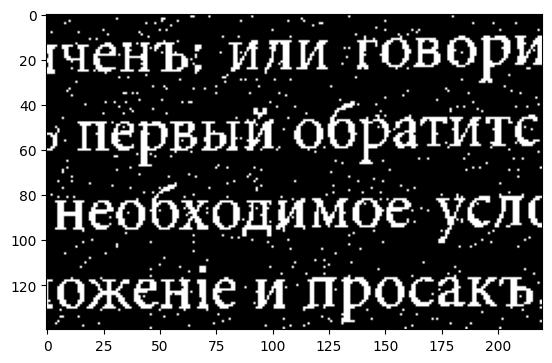

In [13]:
print(sp.shape)
plt.imshow(sp, cmap='gray')
plt.show()

(140, 220)


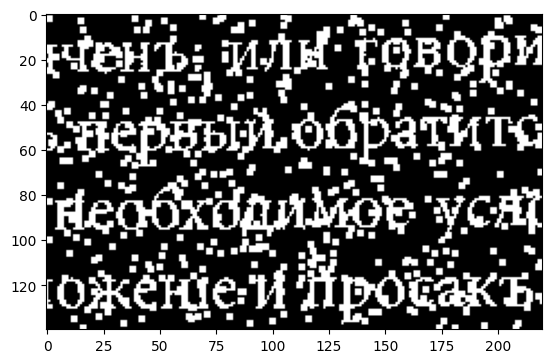

In [14]:
print(crc.shape)
plt.imshow(crc, cmap='gray')
plt.show()

(134, 214) (140, 220)


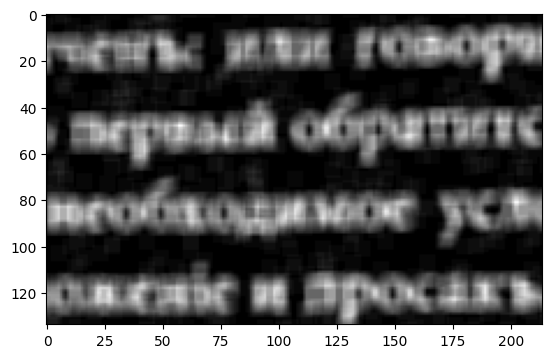

In [15]:
sp_filtred = sliding_window_mean(sp, w_size)
print(sp_filtred.shape, sp.shape)
plt.imshow(sp_filtred, cmap='gray')

(134, 214) (140, 220)


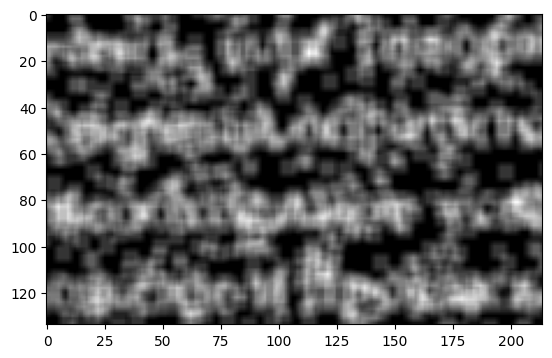

In [16]:
crc_filtred = sliding_window_mean(crc, w_size)
print(crc_filtred.shape, crc.shape)
plt.imshow(crc_filtred, cmap='gray')

In [10]:
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2 - cropx//2
    starty = y//2 - cropy//2    
    return img[starty:starty+cropy, startx:startx+cropx]

In [11]:
def sliding_window_morph(type, f, map, window_size, mean, t):
    assert type == 'sp' or type == 'crc'
    h, w = f.shape
    r_h = (h - window_size[0] + 1)
    r_w = (w - window_size[1] + 1)
    print(r_h, r_w)
    result = crop_center(np.copy(f), r_w, r_h)
    i, j = 0, 0
    for x in range(0, w-window_size[1]+1):
        j = 0
        for y in range(0, h - window_size[0] + 1):
            window_f = f[y:y+window_size[0], x:x+window_size[1]]
            pr = projection_circle(np.copy(window_f)) if type == 'crc' else projection_point(np.copy(window_f))
            a = np.linalg.norm((window_f - pr))**2/np.linalg.norm(pr - E(np.copy(window_f)))**2
            if a < t:
                if type == 'crc':
                    result[j-1:j+2, i-1:i+2] = mean[j-1:j+2, i-1:i+2]
                elif type == 'sp':
                    result[j, i] = mean[j, i]
                map[j, i] = 2 if map[j, i] == 1 else -1
            j += 1
        i += 1
    return result, map

134 214


/tmp/ipykernel_82915/2784845114.py:14: RuntimeWarning: invalid value encountered in scalar divide
  a = np.linalg.norm((window_f - pr))**2/np.linalg.norm(pr - E(np.copy(window_f)))**2


134 214


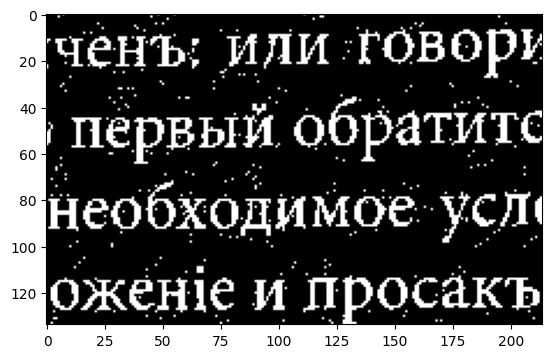

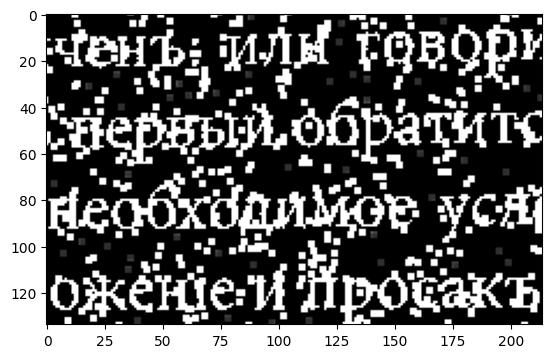

134 214
134 214


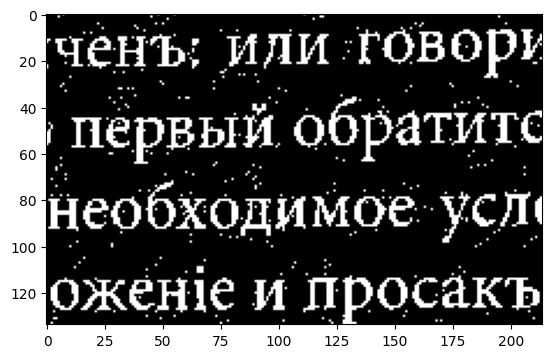

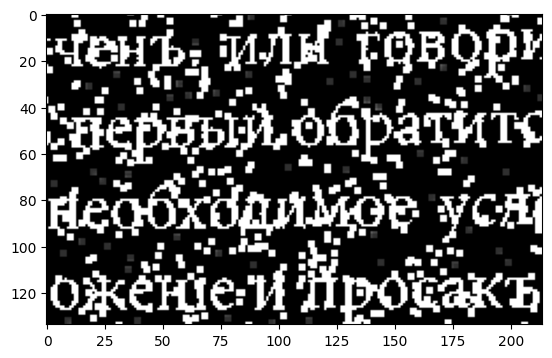

134 214
134 214


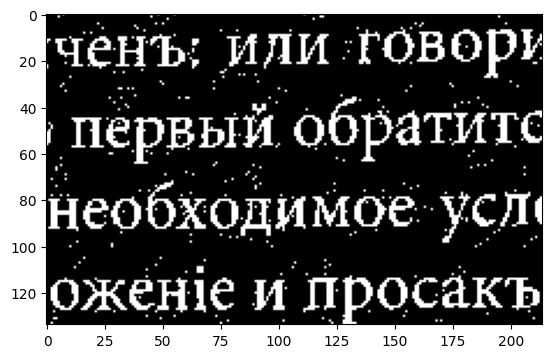

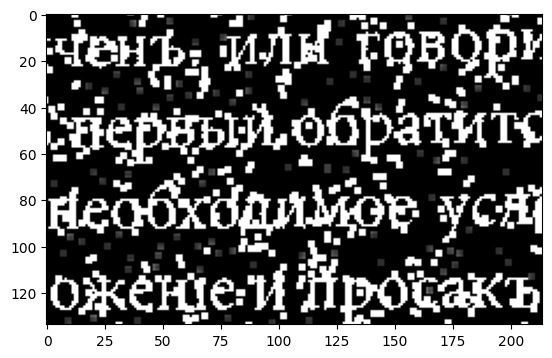

134 214
134 214


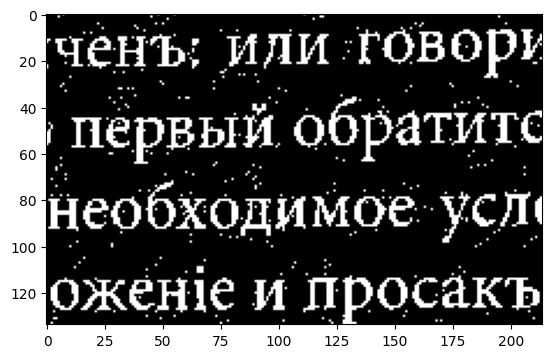

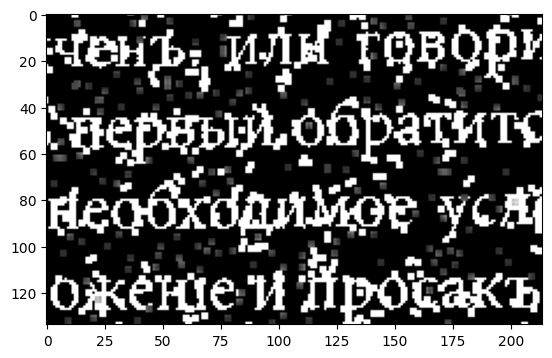

134 214
134 214


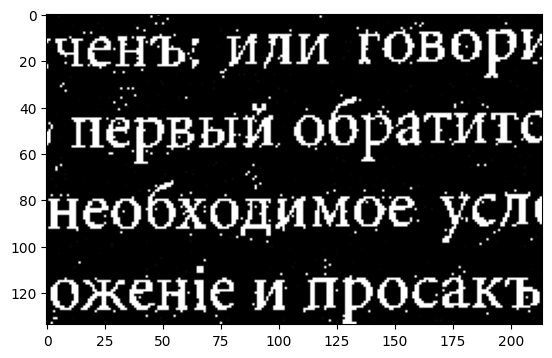

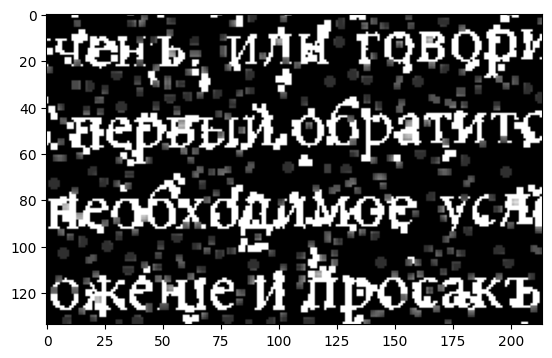

134 214
134 214


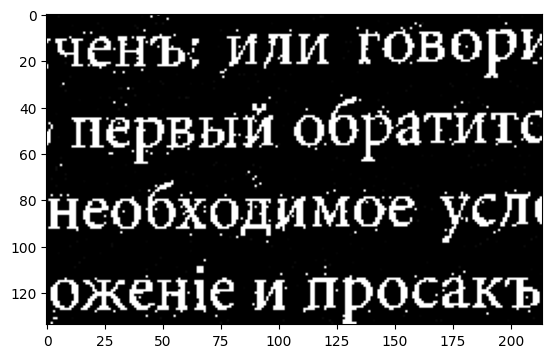

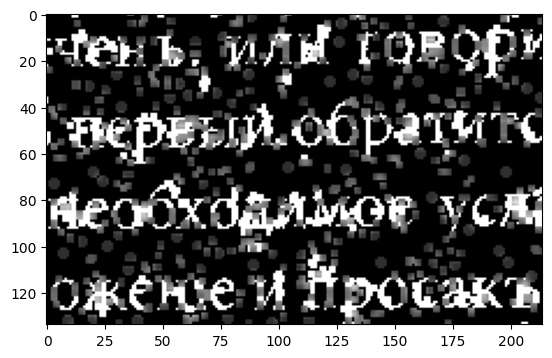

134 214
134 214


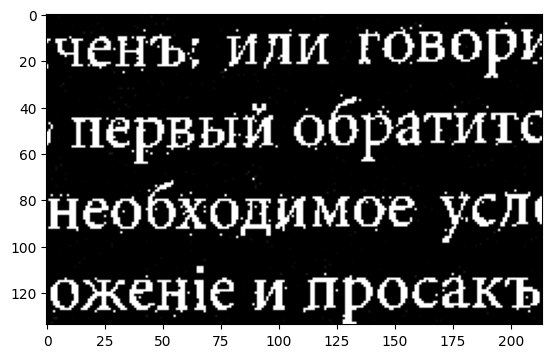

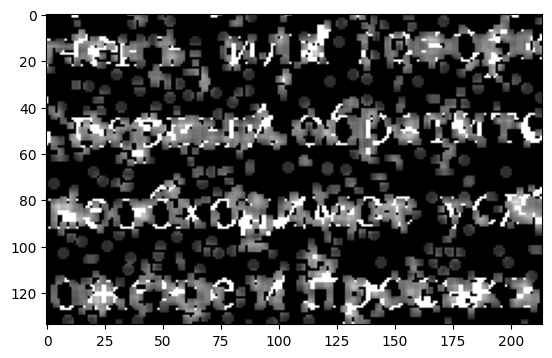

134 214
134 214


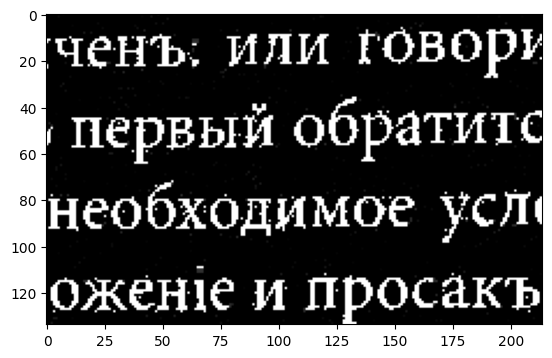

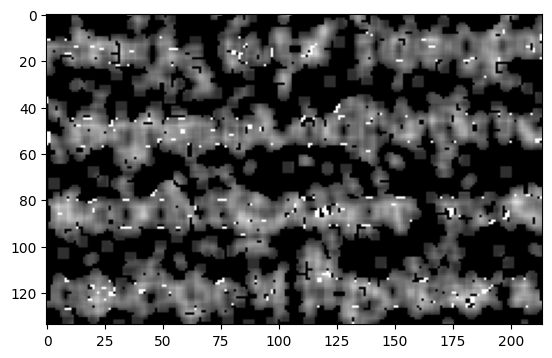

In [18]:
# 1 - пропуск
# -1 ложные срабатывания
a_s = [0.1, 0.2, 0.5, 1, 2, 3, 5, 10]
diffs_sp = []
diffs_crc = []
fn_sp = []
fp_sp = []
fn_crc = []
fp_crc = []
hh,ww = sp_filtred.shape
true_temp = crop_center(true, ww, hh)
for a in a_s:
    sp_morph_filtred, sp_morph_filtred_map = sliding_window_morph('sp', sp.copy(), map_sp.copy(), w_size, sp_filtred.copy(), a)
    crc_morph_filtred, crc_morph_filtred_map = sliding_window_morph('crc', crc.copy(), map_crc.copy(), w_size, crc_filtred.copy(), a)
    plt.imshow(sp_morph_filtred, cmap='gray')
    plt.show()
    plt.imshow(crc_morph_filtred, cmap='gray')
    plt.show()
    diffs_sp.append(np.linalg.norm(sp_morph_filtred - true_temp))
    diffs_crc.append(np.linalg.norm(crc_morph_filtred - true_temp))
    fn_sp.append((sp_morph_filtred_map==1).sum())
    fp_sp.append((sp_morph_filtred_map==-1).sum())
    fn_crc.append((crc_morph_filtred_map==1).sum())
    fp_crc.append((crc_morph_filtred_map==-1).sum())
   
    
    
    

Text(0.5, 1.0, 'Отклонение crc')

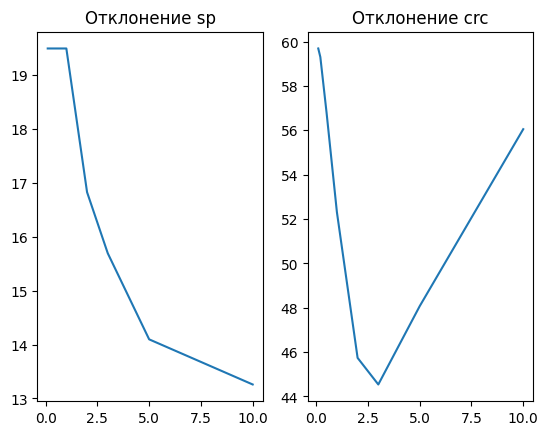

In [19]:
fig, ax = plt.subplots(1,2)
ax[0].plot(a_s, diffs_sp)
ax[0].set_title('Отклонение sp')
ax[1].plot(a_s, diffs_crc)
ax[1].set_title('Отклонение crc')

Text(0.5, 1.0, 'Пропуски crc')

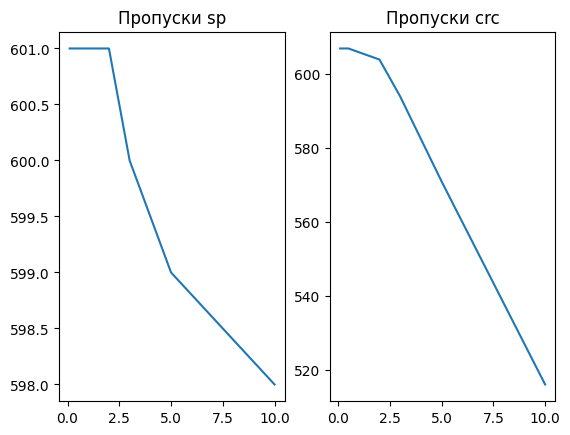

In [20]:
fig, ax = plt.subplots(1,2)
ax[0].plot(a_s, fn_sp)
ax[0].set_title('Пропуски sp')
ax[1].plot(a_s, fn_crc)
ax[1].set_title('Пропуски crc')

Text(0.5, 1.0, 'Ложные срабатывания crc')

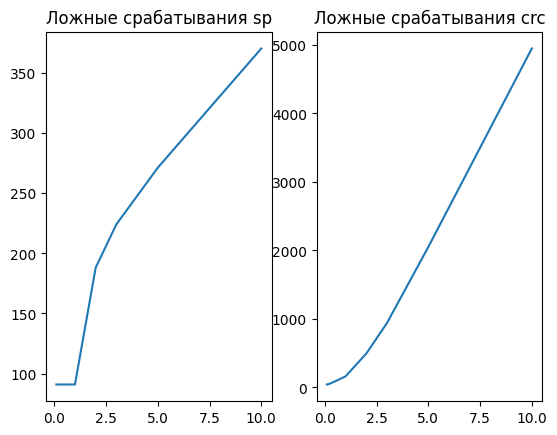

In [21]:
fig, ax = plt.subplots(1,2)
ax[0].plot(a_s, fp_sp)
ax[0].set_title('Ложные срабатывания sp')
ax[1].plot(a_s, fp_crc)
ax[1].set_title('Ложные срабатывания crc')